In [1]:
import numpy as np
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.signal.rotate import rotate2zne
from obspy.core.stream import Stream
from obspy import read,read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.signal.rotate import rotate_ne_rt
from obspy import Trace, Stream
from netCDF4 import Dataset


import matplotlib.pyplot as plt
# import pygmt
font = "11p,Helvetica-Bold"

ModuleNotFoundError: No module named 'pygmt'

+ HHZ/HHN/HHE: High Broad Band Seismometer
+ HNZ/HNN/HNE: High Broad Band Accelerometer  
+ EHZ/EHN/EHE: Short Period 100 sps (Extremely Short Period: T>10s)
+ BHZ/BHN/BHE: Broad Band 20 sps
+ LHZ/LHN/LHE: Long Period 1 sps
+ VHZ/VHN/VHE: Very Long Period 0.1 sps

In [2]:
# Fault geometry
f_fin = Dataset('./mesh/fault.nc','r')
f_lat = f_fin.variables['lat'][:]
f_lon = f_fin.variables['lon'][:]

f_nx = len(f_lon)
f_ny = len(f_lat)

f_depth  = f_fin.variables['z'][:,:]

f_depth = np.asarray(f_depth[:,:])
mask = np.isnan(f_depth )
# f_depth[mask] = 0.0
# f_depth [mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), f_depth [~mask])

In [3]:
X, Y = np.meshgrid(np.linspace(f_lon.min(), f_lon.max(), f_nx), np.linspace(f_lat.min(), f_lat.max(), f_ny))
Z = f_depth
x, y, z = X.flatten(), Y.flatten(), Z.flatten()
x.shape

(21717,)

In [4]:
# Define region of interest around Yosemite valley
region = [-165,-152,52,58]

# Load sample grid (3 arc second global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
# dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

fig = pygmt.Figure()
# define figure configuration
# pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-30000, 500, 100],truncate=[-20000,500])
fig.grdimage(
    grid=grid,
    projection="M15c",
    frame=['lnSWet+t"Hillshade Map"', "xa2.", "ya2."],
    cmap=True,
    shading=True,
)
fig.coast(rivers=0,area_thresh=1000,land="white", resolution='f', shorelines="0.2p,black",transparency=30)

# fig.grdcontour(grid="@earth_age_30s",interval="t.cpt",annotation="+f14p",pen="a0.1p+c",label_placement="L30W/22S/5E/13S")

X, Y = np.meshgrid(np.linspace(f_lon.min(), f_lon.max(), f_nx), np.linspace(f_lat.min(), f_lat.max(), f_ny))
Z = f_depth
x, y, z = X.flatten(), Y.flatten(), Z.flatten()

fig.contour(
    region=region,
    projection="M15c",
#     frame="ag",
    pen="1p,black,--",
    # pass the data as 3 1d data columns
    x=x,
    y=y,
    z=z,
    # set the contours z values intervals to 10
    levels=30,
    # set the contours annotation intervals to 20
    annotation=5,
)

fig.show()



makecpt [ERROR]: gmt_truncate_cpt error: z_low = -20000 less than lowest z (0)
contour [ERROR]: Unrecognized option -a


GMTCLibError: Module 'contour' failed with status code 71:
contour [ERROR]: Unrecognized option -a

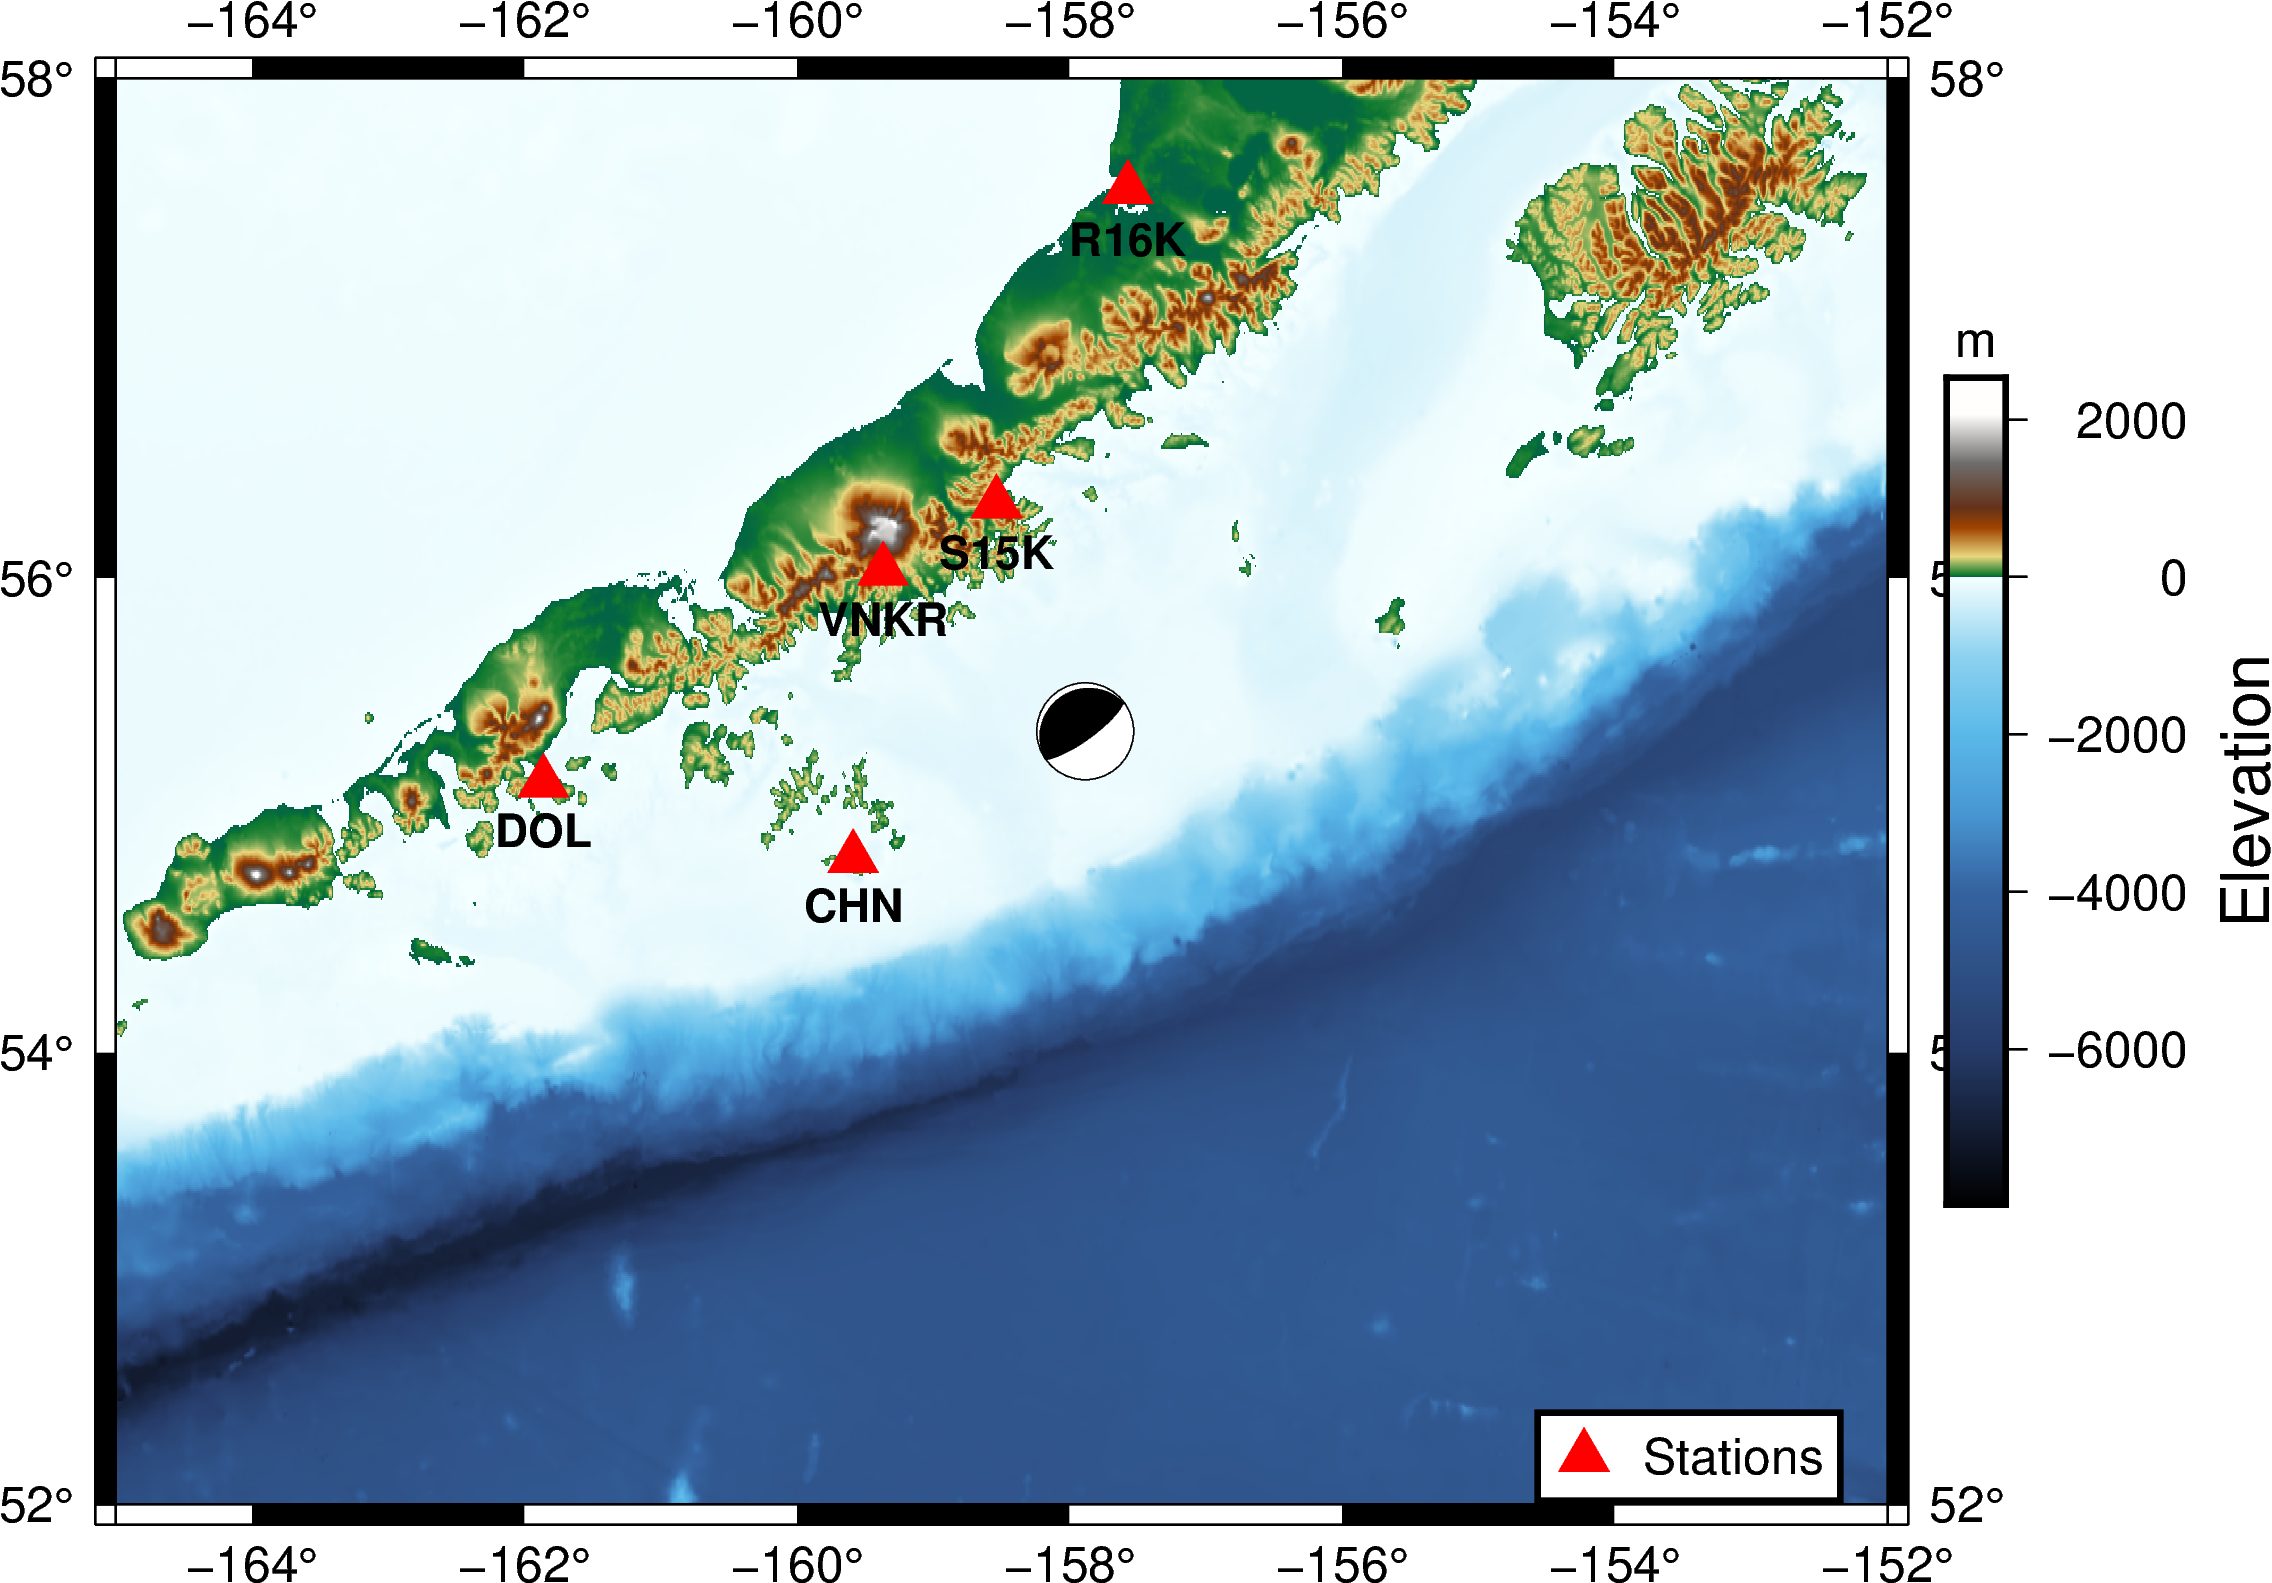

In [5]:
# Focal mechanisms - Alaska M8.2, July 29, 2021  
focal_mechanism = dict(strike=239, dip=14, rake=95, magnitude=8.2)

# Seismic stations 
nw = ['AV','AV','AK','AK','AK']       # network
sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
ch = ['EH*','BH*','HN*','BN*','BH*']      # channel
lon= np.asarray([-159.3699,-161.8638, -158.54, -159.589493,-157.5742])
lat= np.asarray([56.0304, 55.1488, 56.3058, 54.831001,57.5673])

grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-165,-152,52,58])
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap='geo')
fig.meca(focal_mechanism, scale="0.5c", longitude=-157.888, latitude=55.364, depth=35.0) # plot focal mechanism
fig.plot(x=lon, y=lat, style="t0.5c", color='red',label='Stations') # plot stations
fig.text(x=lon, y=lat-0.2, text=sta, font=font) # plot station names
fig.legend(position = 'jBR+jMR+o0.4c', box='+gwhite+p1.5p,black')

fig.colorbar(position="JMR+o0.5c/0c+w7c/0.5c+v",frame=["a2000","x+lElevation", "y+lm"]) # position="x12.5c/6.6c+w6c+jTC+v"
fig.show()


In [4]:
cl_iris  = Client("IRIS")
nw = ['AK','AK','AK']       # network
sta= ['CHN','S15K','S19K']      # station
ch = ['BN*','HN*','HN*']        # channel

# nw = ['AV','AV','AK','AK','AK']       # network
# sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
# ch = ['EHZ','BHZ','HNZ','BHZ','BHZ']      # channel
# Event catalog
cat = cl_iris.get_events(minmagnitude=8.1,maxmagnitude=8.3, starttime=UTCDateTime(2021,7,28),endtime=UTCDateTime(2021,7,30)) # Y
event = cat[0]
print(cat)  

start = event.origins[0].time
end = start + 200

waveform = Stream()

for num in np.arange(len(sta)):
# for num in np.arange(1,2):
    if (num == 0):
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  = inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    else:
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  += inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    st.remove_response(inventory=inv,output='ACC') 
    st.detrend('simple')
    waveform += st
print(waveform)


        

1 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  Mww
9 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples


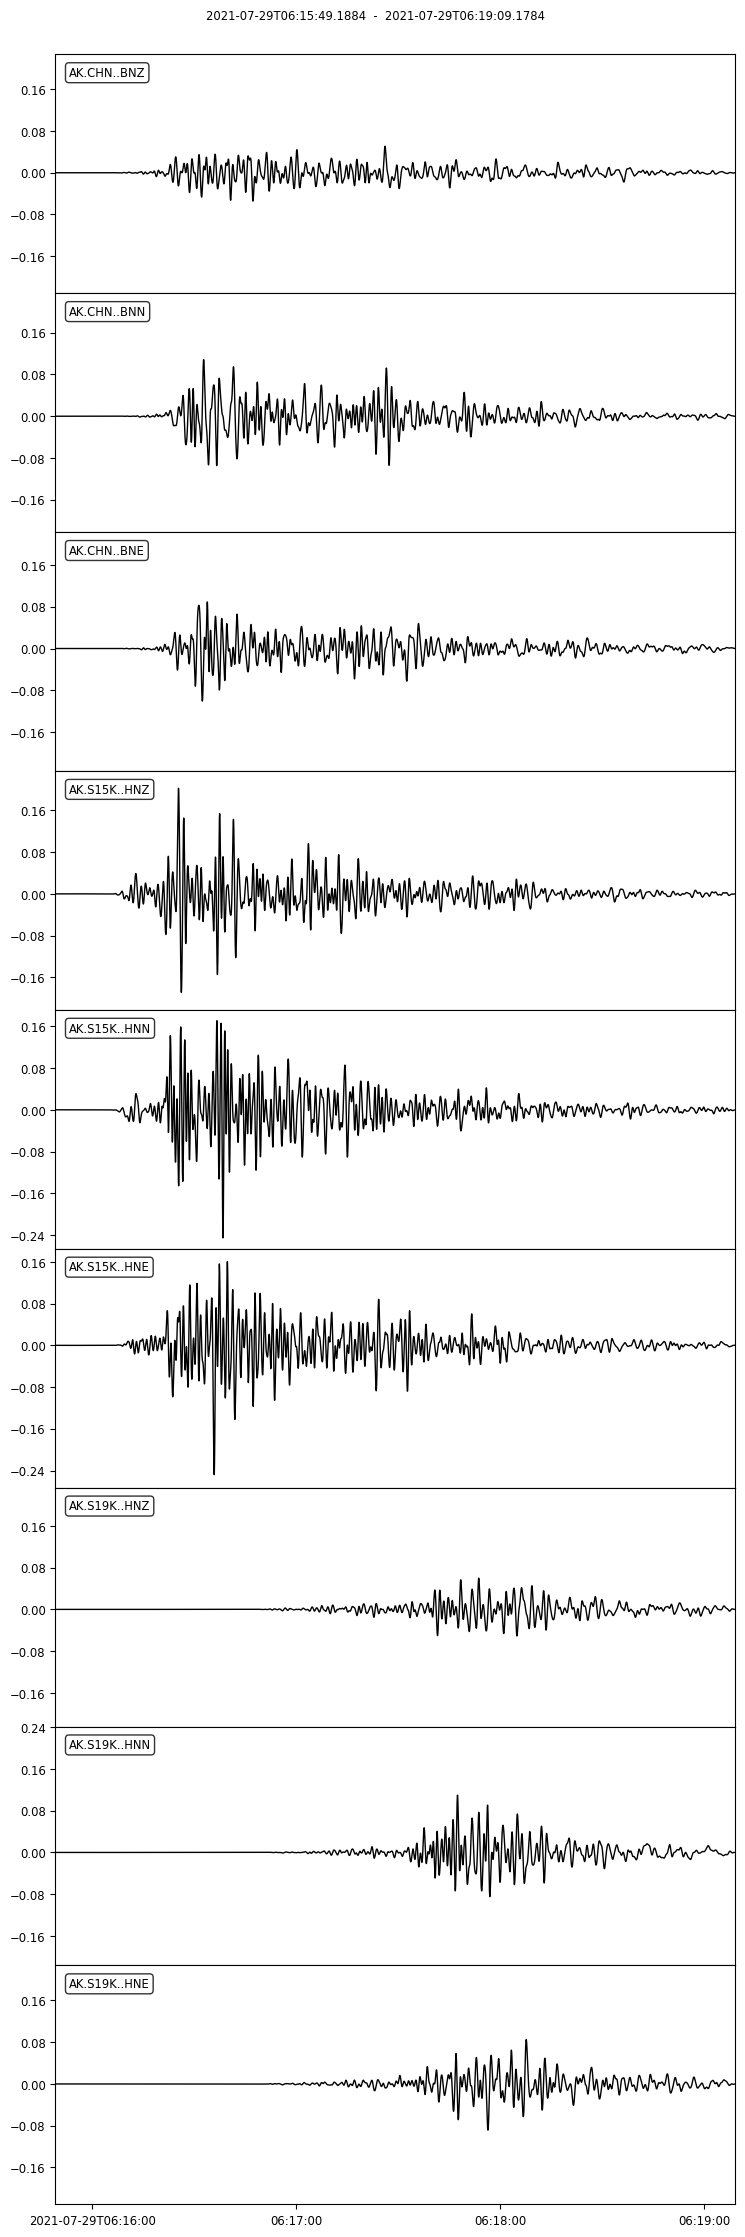

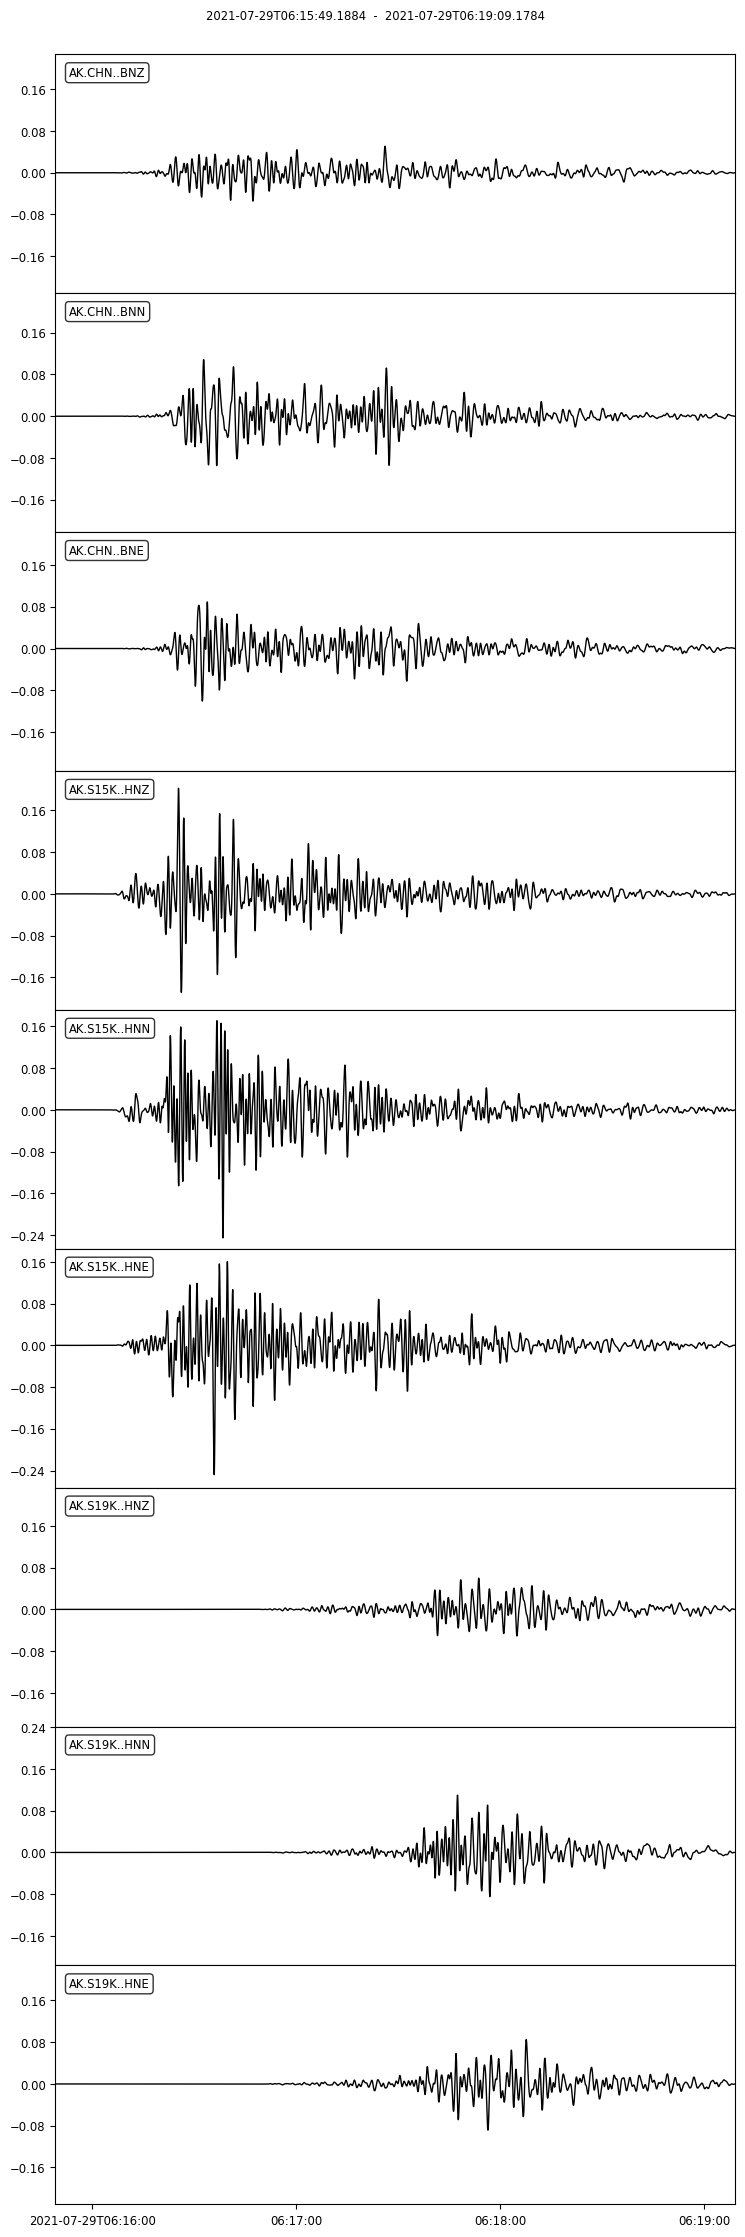

In [5]:
f1 = 0.01
f2 = 1.
waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
waveform1.plot()

In [6]:
# VNFG    56.2849 -159.5532   IRISDMC
# VNHG    56.2203 -159.1663   IRISDMC
# VNKR    56.0304 -159.3699   IRISDMC
# VNNF    56.2829 -159.3181   IRISDMC
# VNSG    56.125  -159.0875   IRISDMC
# VNSS    56.2259 -159.4569   IRISDMC
# VNSW    56.0712 -159.5606   IRISDMC
# VNWF    56.1509 -159.5643   IRISDMC
# CHN
# CHI
# S15K
# FALS
# SII 56.5593 -154.1842


sta= ['CHN','S15K']
ch = ['BNE','BNN','BNZ']
waveform_syn = Stream()
sta_num = 0
for num in np.arange(14,17,2):
#     if num < 10:

    filename = '/import/deadlock-data/dli/Alaska2021/tp75a/alkR057-receiver-%05d.dat'%(num)
    print(filename)
    t, vx, vy, vz = np.loadtxt(filename, comments='#', skiprows=2,usecols=(0,7,8,9),unpack=True)
    st = Stream([Trace(vx),Trace(vy),Trace(vz)])    
    for tr_num in range(3):
        st[tr_num].stats['sampling_rate'] = 200
        st[tr_num].stats['network'] = 'SeisSol'
        st[tr_num].stats['station'] = sta[sta_num] 
        st[tr_num].stats['channel'] = ch[tr_num]
    waveform_syn += st
    sta_num += 1
        
f1 = 0.01
f2 = 0.1
waveform_syn1 = waveform_syn.copy()
waveform_syn1.resample(50.)
waveform_syn1.differentiate()
waveform_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

waveform1 = waveform.copy()
waveform1.resample(50.)
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
           

/import/deadlock-data/dli/Alaska2021/tp75a/alkR057-receiver-00014.dat
/import/deadlock-data/dli/Alaska2021/tp75a/alkR057-receiver-00016.dat


9 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S19K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S19K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S19K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples

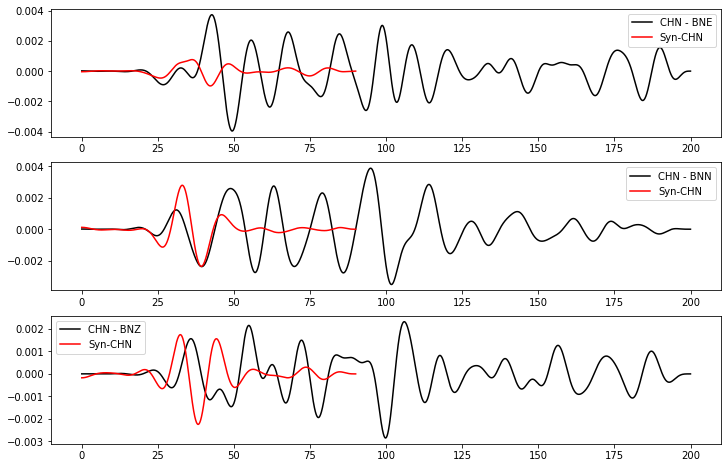

In [7]:
num = 0 # Station CHN

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='BNE')[0].times(),waveform1.select(station=sta[num],channel='BNE')[0].data,'k',label='%s - BNE' %(sta[num]))
ax1.plot(waveform_syn1.select(station=sta[num],channel='BNE')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312)
ax2.plot(waveform1.select(station=sta[num],channel='BNN')[0].times(),waveform1.select(station=sta[num],channel='BNN')[0].data,'k',label='%s - BNN' %(sta[num]))
ax2.plot(waveform_syn1.select(station=sta[num],channel='BNN')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313)
ax3.plot(waveform1.select(station=sta[num],channel='BNZ')[0].times(),waveform1.select(station=sta[num],channel='BNZ')[0].data,'k',label='%s - BNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(station=sta[num],channel='BNZ')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()

S15K


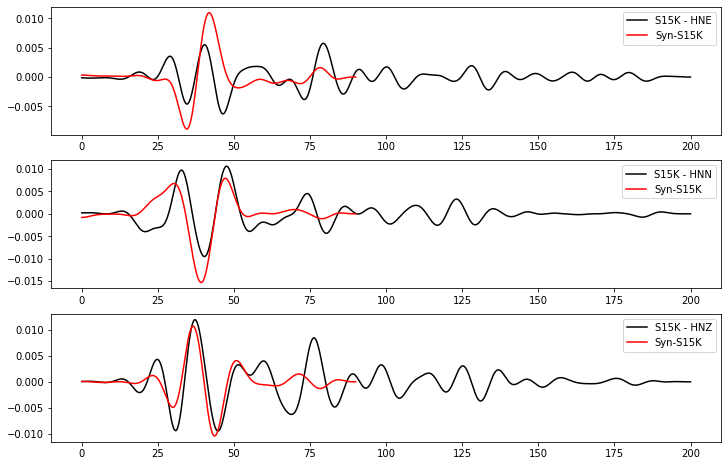

In [40]:
num = 1 # Station S15K
print(sta[num])

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='HNE')[0].times(),waveform1.select(station=sta[num],channel='HNE')[0].data,'k',label='%s - HNE' %(sta[num]))
ax1.plot(waveform_syn1.select(station=sta[num],channel='BNE')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNE')[0].data,'r',label='Syn-%s' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312)
ax2.plot(waveform1.select(station=sta[num],channel='HNN')[0].times(),waveform1.select(station=sta[num],channel='HNN')[0].data,'k',label='%s - HNN' %(sta[num]))
ax2.plot(waveform_syn1.select(station=sta[num],channel='BNN')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNN')[0].data,'r',label='Syn-%s' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313)
ax3.plot(waveform1.select(station=sta[num],channel='HNZ')[0].times(),waveform1.select(station=sta[num],channel='HNZ')[0].data,'k',label='%s - HNZ' %(sta[num]))
ax3.plot(waveform_syn1.select(station=sta[num],channel='BNZ')[0].times(),-waveform_syn1.select(station=sta[num],channel='BNZ')[0].data,'r',label='Syn-%s' %(sta[num]))
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()

In [10]:
# VNFG    56.2849 -159.5532   IRISDMC
# VNHG    56.2203 -159.1663   IRISDMC
# VNKR    56.0304 -159.3699   IRISDMC
# VNNF    56.2829 -159.3181   IRISDMC
# VNSG    56.125  -159.0875   IRISDMC
# VNSS    56.2259 -159.4569   IRISDMC
# VNSW    56.0712 -159.5606   IRISDMC
# VNWF    56.1509 -159.5643   IRISDMC
# CHN
# CHI
# S15K
# FALS
# SII 56.5593 -154.1842


cl_iris  = Client("IRIS")
nw = ['AK','AK','AK']       # network
sta= ['CHN','S15K','S19K']      # station
ch = ['BN*','HN*','HN*']        # channel

# nw = ['AV','AV','AK','AK','AK']       # network
# sta= ['VNKR','DOL','S15K','CHN','R16K']  # station
# ch = ['EHZ','BHZ','HNZ','BHZ','BHZ']      # channel
# Event catalog
cat = cl_iris.get_events(minmagnitude=8.1,maxmagnitude=8.3, starttime=UTCDateTime(2021,7,28),endtime=UTCDateTime(2021,7,30)) # Y
event = cat[0]
print(cat)  

start = event.origins[0].time
end = start + 200

waveform = Stream()

for num in np.arange(len(sta)):
# for num in np.arange(1,2):
    if (num == 0):
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  = inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    else:
        inv = cl_iris.get_stations(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end,level="response")
        inventory  += inv
        st = cl_iris.get_waveforms(network=nw[num],station=sta[num],location='',channel=ch[num],starttime=start,endtime=end)
    st.remove_response(inventory=inv,output='ACC') 
    st.detrend('simple')
    waveform += st
print(waveform)
        
        

1 Event(s) in Catalog:
2021-07-29T06:15:49.188000Z | +55.364, -157.888 | 8.2  Mww
9 Trace(s) in Stream:
AK.CHN..BNE  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNN  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.CHN..BNZ  | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.168400Z | 50.0 Hz, 10000 samples
AK.S15K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S15K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNE | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNN | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples
AK.S19K..HNZ | 2021-07-29T06:15:49.188400Z - 2021-07-29T06:19:09.178400Z | 100.0 Hz, 20000 samples


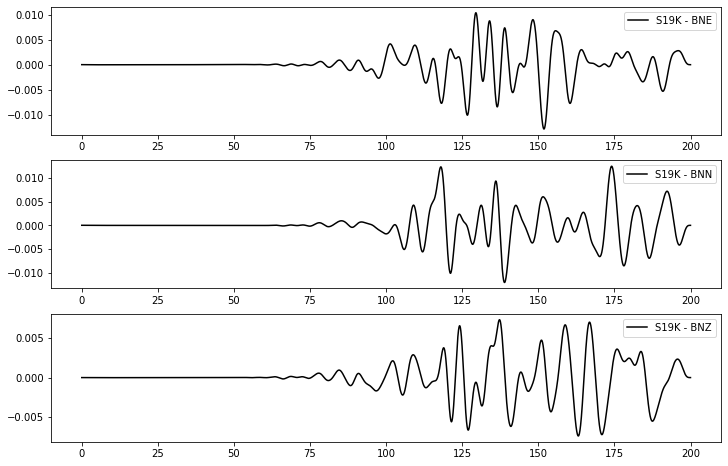

In [11]:
f1 = 0.01
f2 = 0.2
waveform1 = waveform.copy()
waveform1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

num = 2
plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform1.select(station=sta[num],channel='*E')[0].times(),waveform1.select(station=sta[num],channel='*E')[0].data,'k',label='%s - BNE' %(sta[num]))
ax1.legend()

ax2 = plt.subplot(312)
ax2.plot(waveform1.select(station=sta[num],channel='*N')[0].times(),waveform1.select(station=sta[num],channel='*N')[0].data,'k',label='%s - BNN' %(sta[num]))
ax2.legend()

ax3 = plt.subplot(313)
ax3.plot(waveform1.select(station=sta[num],channel='*Z')[0].times(),waveform1.select(station=sta[num],channel='*Z')[0].data,'k',label='%s - BNZ' %(sta[num]))
ax3.legend()

plt.show()

In [46]:
.shape

(1199,)

In [44]:
station = ['ab07','ab13','ac12','ac40','ac41','ac13']
filename2 = './gps/enu_2021210_'+ station[0]
t2, ux, uy, uz = np.loadtxt(filename2, comments='#', skiprows=2,usecols=(1,2,3,4),unpack=True)

In [72]:
# GPS

foldername = 'resultNew/'
foldername = '/import/deadlock-data/dli/Alaska2021/resultNew/'

modelname = 'alkR057-TP73a'
icore = ['088','081','005','081','088','059']

station = ['ab07','ab13','ac12','ac40','ac41','ac13']
stanum = [1,2,3,4,5,19]
ch = ['BNE','BNN','BNZ']

year = '2021'
doy = '210'

print(icore)

waveform_syn = Stream()
waveform_gps = Stream()

    
for i in range(0,6):
    filename1 = './syn_data_new/alkR057-receiver-%05d.dat'%(stanum[i])
    filename2 = './gps/enu_2021210_'+ station[i]
#     dd1 = np.loadtxt(foldername +modelname+'-receiver-000'+ str(stanum[i])+'-00'+str(icore[i])+'.dat', comments='#',skiprows=2)
    
#     dd0 = np.loadtxt('/import/freenas-m-05-seissol/dli/Alaska2021/GPS/enu_2021210_'+ station[i])
    
    t1, vx, vy, vz = np.loadtxt(filename1, comments='#', skiprows=2,usecols=(0,7,8,9),unpack=True)
    st1 = Stream([Trace(vx),Trace(vy),Trace(vz)])    
    for tr_num in range(3):
        st1[tr_num].stats['sampling_rate'] = 200
        st1[tr_num].stats['network'] = 'SeisSol'
        st1[tr_num].stats['station'] = station[i] 
        st1[tr_num].stats['channel'] = ch[tr_num]
    waveform_syn += st1
#     waveform_syn.integrate()
    
    t2, ux, uy, uz = np.loadtxt(filename2, comments='#', skiprows=2,usecols=(1,2,3,4),unpack=True)
    st2 = Stream([Trace(ux),Trace(uy),Trace(uz)])    
    for tr_num in range(3):
        st2[tr_num].stats['sampling_rate'] = 1
        st2[tr_num].stats['network'] = 'gps'
        st2[tr_num].stats['station'] = station[i] 
        st2[tr_num].stats['channel'] = ch[tr_num]
    waveform_gps += st2 
    
    
    t0 = 22567 # OT in gps displacement data from K. Wang.

f1 = 0.01
f2 = 0.1
waveform_syn1 = waveform_syn.copy()
waveform_syn1.resample(1.)
waveform_syn1.integrate()
waveform_syn1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)

waveform_gps1 = waveform_gps.copy()
waveform_gps1.resample(1.)
# waveform_gps1.filter('bandpass',freqmin=f1,freqmax=f2, corners=4, zerophase=True)
  


['088', '081', '005', '081', '088', '059']


18 Trace(s) in Stream:
gps.ab07..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ab07..BNN | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ab07..BNZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ab13..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ab13..BNN | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ab13..BNZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ac12..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ac12..BNN | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ac12..BNZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ac40..BNE | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:19:58.000000Z | 1.0 Hz, 1199 samples
gps.ac4

ab13


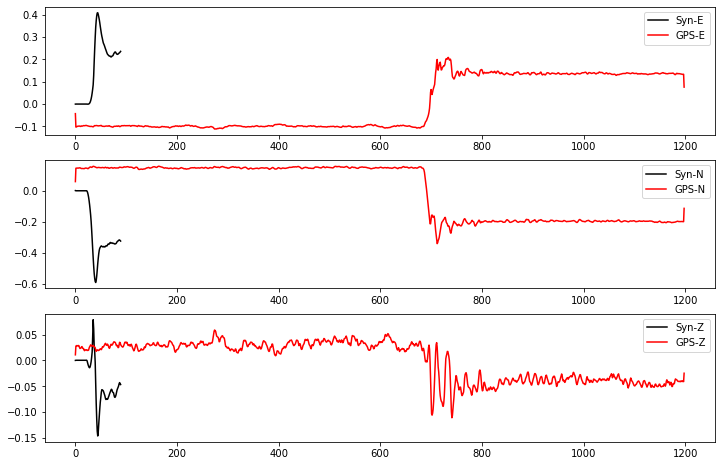

In [73]:
num = 1 # Station S15K
print(station[num])

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(311)
ax1.plot(waveform_syn1.select(station=station[num],channel='BNE')[0].times(),waveform_syn1.select(station=station[num],channel='BNE')[0].data,'k',label='Syn-E' )
ax1.plot(waveform_gps1.select(station=station[num],channel='BNE')[0].times(),waveform_gps1.select(station=station[num],channel='BNE')[0].data,'r',label='GPS-E' )
ax1.legend()

ax2 = plt.subplot(312)
ax2.plot(waveform_syn1.select(station=station[num],channel='BNN')[0].times(),waveform_syn1.select(station=station[num],channel='BNN')[0].data,'k',label='Syn-N')
ax2.plot(waveform_gps1.select(station=station[num],channel='BNN')[0].times(),waveform_gps1.select(station=station[num],channel='BNN')[0].data,'r',label='GPS-N')
ax2.legend()

ax3 = plt.subplot(313)
ax3.plot(waveform_syn1.select(station=station[num],channel='BNZ')[0].times(),waveform_syn1.select(station=station[num],channel='BNZ')[0].data,'k',label='Syn-Z')
ax3.plot(waveform_gps1.select(station=station[num],channel='BNZ')[0].times(),waveform_gps1.select(station=station[num],channel='BNZ')[0].data,'r',label='GPS-Z')
ax3.legend()

# ax3.set_xlabel('Time [s]')

plt.show()

In [ ]:
##
plt.figure(figsize=(6,5))

ax1 = plt.subplot(311)
#     plt.plot(dd0[:,1]-t0,dd0[:,2])
plt.plot(dd0[:,1]-t0,dd0[:,3]-np.mean(dd0[0:666,3]),'k')
#     plt.plot(stream[0].times(),stream[0].data)
plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,8]),'r')

plt.legend(['obv.','syn.'],loc=4)
#     ax1.set_ylim([-0.6, 0.0])
ax1.set(xlim=([0, 180]))
plt.ylabel('N (m)')
plt.title(station[i])

ax2 = plt.subplot(312,sharex=ax1)
plt.plot(dd0[:,1]-t0,dd0[:,2]-np.mean(dd0[0:666,2]),'k')
#     plt.plot(stream[0].times(),stream[1].data)
plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,7]),'r')
#     plt.legend([station[i]+' ', 'syn.'],loc=4)
#     plt.ylim([0.0, 0.5])
#     plt.xlim([0, 180])
plt.ylabel('E (m)')

ax3 = plt.subplot(313,sharex=ax1)
plt.plot(dd0[:,1]-t0,dd0[:,4]-np.mean(dd0[0:666,4]),'k')
#     plt.plot(stream[0].times(),stream[2].data)
plt.plot(dd1[:,0],0.005*np.cumsum(dd1[:,9]),'r')
#     plt.legend([station[i]+' ', 'syn.'],loc=4)
#     plt.ylim([-0.0, 0.7])
#     plt.xlim([0, 180])
plt.xlabel('time after OT(s)')
plt.ylabel('U (m)')
    # plt.ylim(-350000,350000)      
plt.savefig('disp_'+ modelname + '_' + station[i] +'.png',dpi=150)